## Setup

In [1]:
!pip install -q google-cloud-aiplatform

     |████████████████████████████████| 1.2 MB 8.2 MB/s 
     |████████████████████████████████| 105 kB 50.6 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 104 kB 52.1 MB/s 
     |████████████████████████████████| 104 kB 54.2 MB/s 
     |████████████████████████████████| 103 kB 54.2 MB/s 
     |████████████████████████████████| 103 kB 41.1 MB/s 
     |████████████████████████████████| 103 kB 53.8 MB/s 
     |████████████████████████████████| 103 kB 51.8 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 96 kB 6.3 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 92 kB 12.1 MB/s 
     |████████████████████████████████| 92 kB 10.9 MB/s 
     |█████████████████████████

***Please restart the runtime after installation.***

## Imports

In [1]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import base64

from google.cloud.aiplatform.gapic.schema import predict
from google.cloud import aiplatform
import tensorflow as tf

## Utility functions

In [2]:
def preprocess_image(image):
    """Preprocesses an image."""
    image = np.array(image)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.uint8)
    return image[None, ...]

def load_image_from_url(url):
    """Loads an image from a URL. Please provide a URL of a valid RGB image."""
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image

def tflite_inference(tflite_model_path, image):
    """Runs inference with a TFLite model."""
    # Load the TFLite model from its patth and allocate tensors into memory.
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get the indices of input and output of the model.
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Scale if needed. 
    if input_details["dtype"] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        image = tf.cast(image, tf.float32)
        image = image / input_scale + input_zero_point
        image = tf.cast(image, tf.uint8)

    # Run inference.
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    flower_id = np.argmax(probability[0])
    return flower_id

## Load an image

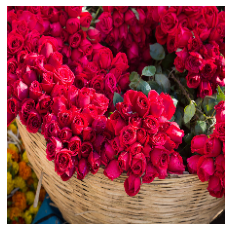

In [3]:
image = load_image_from_url("https://m.economictimes.com/thumb/msid-71307470,width-1201,height-900,resizemode-4,imgsize-1040796/roses.jpg")
plt.imshow(image[0])
plt.axis("off")
plt.show()

## Load the TFLite model

In [4]:
tflite_model_path = tf.keras.utils.get_file("model.tflite", 
                                            "https://storage.googleapis.com/output-model-gde-csp/flower-models/model-8119506343032782848/tflite/2021-07-28T15%3A48%3A15.623623Z/model.tflite")

3186688/3183914 [==============================] - 0s 0us/step


## Performing inference with the TFLite model

In [5]:
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
CLASSES[tflite_inference(tflite_model_path, image)]

'roses'

Note that for other images, it's expected to get wrong predictions since this model was not trained for accuracy. It was trained for achieving better inference speed. 

## Predictions with the Vertex AI Endpoint

In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
# Reference:
# https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-automl
def predict_image_classification_sample(
    project: str,
    endpoint_id: str,
    filename: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance = predict.instance.ImageClassificationPredictionInstance(
        content=encoded_content,
    ).to_value()
    instances = [instance]
    # See gs://google-cloud-aiplatform/schema/predict/params/image_classification_1.0.0.yaml for the format of the parameters.
    parameters = predict.params.ImageClassificationPredictionParams(
        confidence_threshold=0.5, max_predictions=5,
    ).to_value()
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # See gs://google-cloud-aiplatform/schema/predict/prediction/classification.yaml for the format of the predictions.
    predictions = response.predictions
    for prediction in predictions:
        print(" prediction:", dict(prediction))


In [8]:
image_path = tf.keras.utils.get_file("image.jpg", 
                                            "https://m.economictimes.com/thumb/msid-71307470,width-1201,height-900,resizemode-4,imgsize-1040796/roses.jpg")

predict_image_classification_sample(
    project="881543627888",
    endpoint_id="2892911849701900288",
    location="us-central1",
    filename=image_path
)

229376/221658 [===============================] - 0s 1us/step
response
 deployed_model_id: 3634976645334433792
 prediction: {'confidences': [0.993417144], 'displayNames': ['roses'], 'ids': ['7685934823340244992']}
